In [27]:
from IPython.display import clear_output
# !pip install stanza
# from google.colab import drive
# drive.mount('/content/drive')

import os

import pandas as pd

import torch
from torchtext.legacy import data
import torch.nn as nn
import numpy as np

clear_output()
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [28]:
base_path = os.path.abspath('..')
project_path = os.path.join(base_path, 'emotion-classification')

df = pd.read_csv(os.path.join(project_path, 'data/train.csv'), index_col=0)
df = pd.concat([df, pd.read_csv(os.path.join(project_path, 'data/test.csv'), index_col=0)])

# Only include utterances with more than 5 characters
df = df[df['prompt'].str.len() > 5]
df = df.reset_index(drop=True)

# Add _text suffix
df.rename({'prompt': 'prompt_text'}, axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df.head()

,prompt_text,label
0,I remember going to the fireworks with my best...,28
1,i used to scare for darkness,0
2,I showed a guy how to run a good bead in weldi...,26
3,I have always been loyal to my wife.,15
4,A recent job interview that I had made me feel...,30


In [29]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, random_state=42, test_size=0.2)
train_df, val_df = train_test_split(train_df, random_state=42, test_size=0.2)

In [30]:
TEXT = data.Field(tokenize = 'moses', include_lengths = True)
LABEL = data.LabelField()

In [31]:
class DataFrameDataset(data.Dataset):
    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.label if not is_test else None
            text = row.prompt_text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)


In [32]:
fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds, test_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=val_df, test_df=test_df)

In [1]:
MAX_VOCAB_SIZE = 25000

# all possible embedding options:
# fasttext.en.300d fasttext.simple.300d glove.42B.300d 
# glove.840B.300d glove.twitter.27B.25d glove.twitter.27B.50d 
# glove.twitter.27B.100d glove.twitter.27B.200d glove.6B.50d 
# glove.6B.100d glove.6B.200d glove.6B.300d
TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)

NameError: name 'TEXT' is not defined

In [34]:
LABEL.build_vocab(train_ds)

In [35]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [36]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 512
OUTPUT_DIM = len(df['label'].unique())
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

In [37]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text dims: [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded dims:  [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu().int())
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output dims: [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden dims: [num layers * num directions, batch size, hid dim]
        #cell dims: [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # these are the outputs from the last token
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden dims: [batch size, hid dim * num directions]
            
        hidden = self.fc1(hidden)
        hidden = self.dropout(hidden)
        return self.fc2(hidden)


In [38]:
model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [39]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0198,  0.5900, -0.2751,  ...,  0.2233,  0.3754,  0.4478],
        [ 0.2535,  0.5517,  0.0076,  ...,  0.4661,  0.1691,  0.2835],
        [ 0.0623, -0.7013, -0.4708,  ...,  0.5110, -0.2204, -0.1306]])

In [40]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# print(model.embedding.weight.data[0])

In [41]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
from sklearn.metrics import f1_score
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths.int()).squeeze(1)
        # print(predictions.shape)
        loss = criterion(predictions, batch.label)

        loss.backward()
        optimizer.step()
        preds = torch.argmax(predictions, 1).cpu()
        acc = f1_score(preds, batch.label.cpu(), average='macro')
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [43]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths.cpu().int()).squeeze(1)
            preds = torch.argmax(predictions, 1).cpu()
            acc = f1_score(preds, batch.label.cpu(), average='macro')
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [44]:
import time
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 2.955 | Train Acc: 10.09%
	 Val. Acc: 22.86%
	Train Loss: 2.156 | Train Acc: 28.72%
	 Val. Acc: 32.14%
	Train Loss: 1.756 | Train Acc: 39.75%
	 Val. Acc: 38.04%
	Train Loss: 1.475 | Train Acc: 47.39%
	 Val. Acc: 40.91%
	Train Loss: 1.226 | Train Acc: 54.22%
	 Val. Acc: 40.86%
	Train Loss: 1.032 | Train Acc: 61.14%
	 Val. Acc: 39.98%
	Train Loss: 0.861 | Train Acc: 66.71%
	 Val. Acc: 41.31%
	Train Loss: 0.689 | Train Acc: 72.76%
	 Val. Acc: 39.90%
	Train Loss: 0.540 | Train Acc: 78.26%
	 Val. Acc: 40.28%
	Train Loss: 0.438 | Train Acc: 82.10%
	 Val. Acc: 39.60%
	Train Loss: 0.321 | Train Acc: 86.54%
	 Val. Acc: 38.06%
	Train Loss: 0.252 | Train Acc: 89.91%
	 Val. Acc: 39.17%
	Train Loss: 0.217 | Train Acc: 91.13%
	 Val. Acc: 39.41%
	Train Loss: 0.156 | Train Acc: 93.47%
	 Val. Acc: 39.77%
	Train Loss: 0.138 | Train Acc: 94.38%
	 Val. Acc: 38.30%
	Train Loss: 0.113 | Train Acc: 95.45%
	 Val. Acc: 38.57%
	Train Loss: 0.105 | Train Acc: 95.74%
	 Val. Acc: 38.34%
	Train Loss: 0

<function matplotlib.pyplot.show>

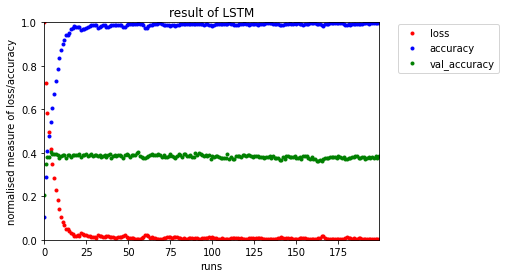

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

## Transfer Learning with BERT 